# Reconstruction from interpolated values with known locations

In [2]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [3]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.interpolate import *
from src.algorithm import conjugate_gradient
import jax
from src.utils import mip_z

Create the grids and the volume

In [4]:
nx = 5

x_freq = jnp.fft.fftfreq(nx, 1/nx)
y_freq = x_freq
z_freq = x_freq

X, Y, Z = jnp.meshgrid(x_freq, y_freq, z_freq)


x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

vol = jnp.array(np.random.randn(nx,nx,nx)) + jnp.array(np.random.randn(nx,nx,nx))*1j + 100+80j

all_coords = jnp.array([X.ravel(), Y.ravel(), Z.ravel()])

Generate points on or off the grid

In [77]:
N = 2000

# The points will be on the grid between low and high. 
# Going outside the range by half, to ensure wrap-around works well.
low = -3*nx
high = 3*nx

# Actually not going outside the range for now
#low = -nx/2
#high = nx/2

#pts = jnp.array(np.random.randint(low, high, size = (3,N))).astype(jnp.float64)

# Points between grid points
pts = 3*nx * np.random.randn(3,N)


In [78]:
@jax.jit
def interpolate_fun(vol):
    return interpolate(pts, x_grid, y_grid, z_grid, vol, "tri")

The interpolated values, i.e. the data. When the points above are on the grid, this is the volume.

In [79]:
data = interpolate_fun(vol)

In [143]:
@jax.jit
def loss_fun(v):
    #return 1/(2*len(data))*jnp.sum((interpolate_fun(v) - data)**2)
    
    diff = interpolate_fun(v) - data
    return 1/(2*len(data))*jnp.sum(jnp.real(jnp.conj(diff)*diff))



@jax.jit
def loss_fun_grad(v):
    return jax.grad(loss_fun)(v)

In [144]:
loss_fun(vol)

DeviceArray(0., dtype=float64)

In [145]:
loss_fun_grad(vol).shape

(5, 5, 5)

And solve the inverse problem

In [162]:
v0 = jnp.array(np.random.randn(nx,nx,nx))*1j
#v0 = vol + 0.1*np.random.randn(nx,nx,nx)


vk = v0
N_iter = 2000
alpha = 100
for k in range(N_iter):
    vk = vk - alpha * jnp.conj(loss_fun_grad(vk))
    
    if jnp.mod(k,100) == 0:
        loss = loss_fun(vk)
        print("iter ", k, ", loss = ", loss)

err = jnp.max(jnp.abs(vk-vol))
print("err =", err)

iter  0 , loss =  325.7604732137389
iter  100 , loss =  2.844910248360346e-05
iter  200 , loss =  1.429848384588433e-08
iter  300 , loss =  7.788172201293263e-12
iter  400 , loss =  4.287505793313481e-15
iter  500 , loss =  2.366271763609849e-18
iter  600 , loss =  1.3072048751017493e-21
iter  700 , loss =  7.230737932321204e-25
iter  800 , loss =  9.132106274328104e-28
iter  900 , loss =  7.588210819501957e-28
iter  1000 , loss =  7.588210819501957e-28
iter  1100 , loss =  7.588210819501957e-28
iter  1200 , loss =  7.588210819501957e-28
iter  1300 , loss =  7.588210819501957e-28
iter  1400 , loss =  7.588210819501957e-28
iter  1500 , loss =  7.588210819501957e-28
iter  1600 , loss =  7.588210819501957e-28
iter  1700 , loss =  7.588210819501957e-28
iter  1800 , loss =  7.588210819501957e-28
iter  1900 , loss =  7.588210819501957e-28
err = 3.7193366120795873e-13


In [163]:
jnp.max(jnp.abs(vk-vol))

DeviceArray(3.71933661e-13, dtype=float64)

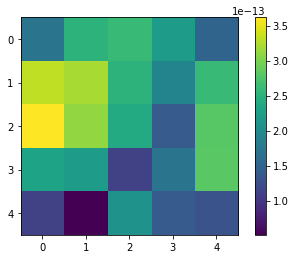

In [148]:
mip_z(jnp.abs(vk-vol));plt.colorbar()

In [172]:
v0 = jnp.array(np.random.randn(nx,nx,nx))*1j
zero = jnp.zeros(vol.shape)*1j
Ab = -jnp.conj(loss_fun_grad(zero))
AA = lambda a : jnp.conj(loss_fun_grad(a)) + Ab


vcg, max_iter = conjugate_gradient(AA, Ab, v0, 50, verbose = True)
err = jnp.max(jnp.abs(vcg-vol))
print("err =", err)

Iter 0 ||r|| = 0.7572755577670577
Iter 1 ||r|| = 0.22333473994375475
Iter 2 ||r|| = 0.0861691036426202
Iter 3 ||r|| = 0.03921262083928183
Iter 4 ||r|| = 0.02235549682345077
Iter 5 ||r|| = 0.013573026803236087
Iter 6 ||r|| = 0.00713393223113184
Iter 7 ||r|| = 0.004918958200078823
Iter 8 ||r|| = 0.0029261402949828613
Iter 9 ||r|| = 0.002089121252260642
Iter 10 ||r|| = 0.001400204374828413
Iter 11 ||r|| = 0.0009324114475433833
Iter 12 ||r|| = 0.0005543640547665779
Iter 13 ||r|| = 0.0003164004512264793
Iter 14 ||r|| = 0.0002240725351385824
Iter 15 ||r|| = 0.00013463483141737433
Iter 16 ||r|| = 8.034405436886502e-05
Iter 17 ||r|| = 4.928889400267662e-05
Iter 18 ||r|| = 3.025375690089728e-05
Iter 19 ||r|| = 1.7691419763813366e-05
Iter 20 ||r|| = 1.1019535037845197e-05
Iter 21 ||r|| = 6.054845732831041e-06
Iter 22 ||r|| = 3.112597036947908e-06
Iter 23 ||r|| = 1.6927030871521472e-06
Iter 24 ||r|| = 9.77249497780672e-07
Iter 25 ||r|| = 5.156433017065327e-07
Iter 26 ||r|| = 2.969787028047763e-07

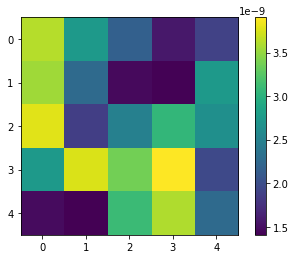

In [175]:
mip_z(jnp.abs(vcg-vol));plt.colorbar()